## 2. Embedding
First I modified the embedding visualization code to zoom in on an interesting cluster of tokens, shown below. Religious terms got grouped together.

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import sys
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.figsize'] = [100, 60]

model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking')
model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')

tokenizer.save_vocabulary(save_directory='.')

print("The vocabulary size is: ", model.config.vocab_size) 

2024-03-29 16:29:39.388570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.tran

The vocabulary size is:  30522


In [2]:
wordembs = model.get_input_embeddings()
allinds = np.arange(0,model.config.vocab_size,1)
inputinds = torch.LongTensor(allinds)
bertwordembs = wordembs(inputinds).detach().numpy()
print(bertwordembs.shape)

(30522, 1024)


In [5]:
bertwordembs[0:3,0:3]

array([[-0.02419428, -0.00759981,  0.00445366],
       [-0.02851291, -0.05074956, -0.01274622],
       [-0.01905373, -0.05421471, -0.00300475]], dtype=float32)

In [6]:
filename = "vocab.txt"
with open(filename,'r') as f:
    bertwords = np.array([])
    for line in f:
        bertwords = np.append(bertwords, line.rstrip())

# Determine vocabulary to use for t-SNE/visualization. The indices are hard-coded based partially on inspection:
bert_char_indices_to_use = np.arange(999, 1063, 1)
bert_voc_indices_to_plot = np.append(bert_char_indices_to_use, np.arange(1996, 5932, 1))
bert_voc_indices_to_use = np.append(bert_char_indices_to_use, np.arange(1996, 11932, 1))

bert_voc_indices_to_use_tensor = torch.LongTensor(bert_voc_indices_to_use)
bert_word_embs_to_use = wordembs(bert_voc_indices_to_use_tensor).detach().numpy()
bert_words_to_plot = bertwords[bert_voc_indices_to_plot]

print(len(bert_voc_indices_to_plot))
print(len(bert_voc_indices_to_use))

4000
10000


In [7]:
# Run t-SNE on the BERT vocabulary embeddings we selected:
mytsne_words = TSNE(n_components=2,early_exaggeration=12,verbose=2,metric='cosine',init='pca',n_iter=2500)
bert_word_embs_to_use_tsne = mytsne_words.fit_transform(bert_word_embs_to_use)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.404s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.267747
[t-SNE] Computed conditional probabilities in 0.198s
[t-SNE] Iteration 50: error = 97.8549042, gradient norm = 0.0075994 (50 iterations in 0.603s)
[t-SNE] It

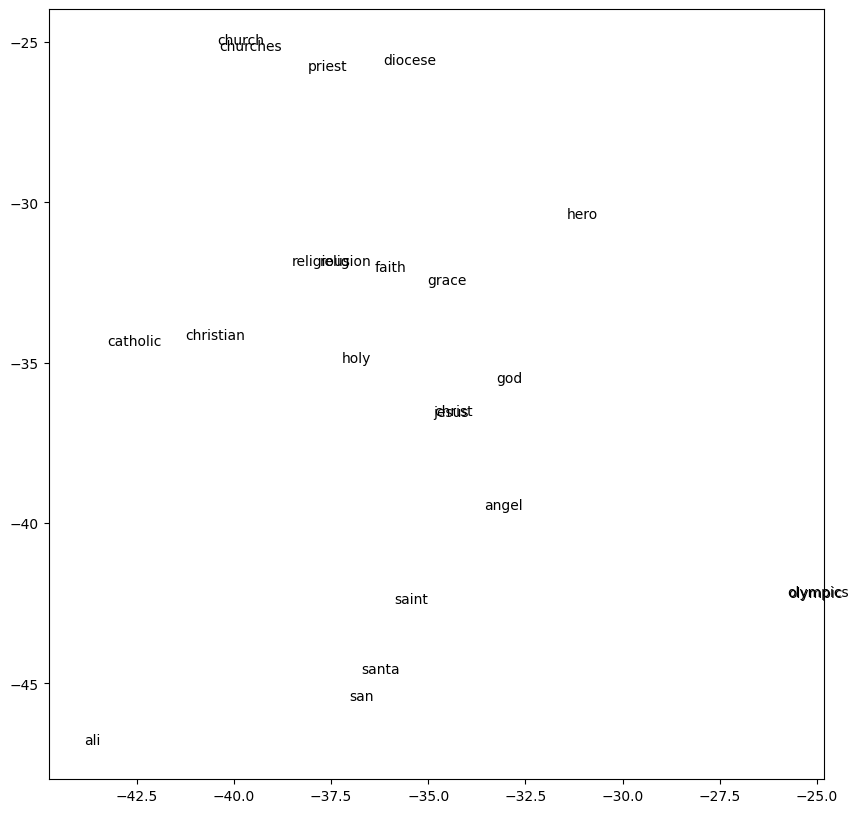

In [9]:
# Plot the transformed BERT vocabulary embeddings:
fig = plt.figure(figsize = (10,10))
alltexts = []
for i, txt in enumerate(bert_words_to_plot):
    x = bert_word_embs_to_use_tsne[i,0]
    y = bert_word_embs_to_use_tsne[i,1]
    
    if -45 < x and x < -25 and -50 < y and y < -25:
        plt.scatter(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], s=0)
        currtext = plt.text(bert_word_embs_to_use_tsne[i,0], bert_word_embs_to_use_tsne[i,1], txt, family='sans-serif')
        alltexts.append(currtext)
plt.show;

### Let's write an elementary tokenizer that uses words as tokens.

We will use Mark Twain's _Life On The Mississippi_ as a test bed. The text is in the accompanying file 'Life_On_The_Mississippi.txt'

Here's a not-terribly-good such tokenizer:

## 1. Tokenization

In [1]:
import string
import re

In [4]:
remove_punct = str.maketrans('', '', string.punctuation)

wdict = {}
with open('Life_On_The_Mississippi.txt', 'r') as L:
    line = L.readline()
    nlines = 1
    while line:
        line = line.translate(remove_punct)
        line = re.sub(r'[^\x00-\x7F]', '', line)
        line = line.lower()
        words = line.split()
        for word in words:
            if wdict.get(word) is not None:
                wdict[word] += 1
            else:
                wdict[word] = 1
        line = L.readline()
        nlines += 1

nitem = 0 ; maxitems = 10
for item in wdict.items():
    nitem += 1
    print(item)
    if nitem == maxitems: break


('the', 9255)
('project', 90)
('gutenberg', 87)
('ebook', 13)
('of', 4532)
('life', 89)
('on', 947)
('mississippi', 159)
('this', 781)
('is', 1148)


This is unsatisfactory for a few reasons:

* There are non-ASCII (Unicode) characters that should be stripped (the so-called "Byte-Order Mark" or BOM \ufeff at the beginning of the text);

* There are punctuation marks, which we don't want to concern ourselves with;

* The same word can appear capitalized, or lower-case, or with its initial letter upper-cased, whereas we want them all to be normalized to lower-case.

Part 1 of this assignment: insert code in this loop to operate on the str variable 'line' so as to fix these problems before 'line' is split into words.

A hint to one possible way to do this: use the 'punctuation' character definition in the Python 'string' module, the 'maketrans' and 'translate' methods of Python's str class, to eliminate punctuation, and the regular expression ('re') Python module to eliminate any Unicode---it is useful to know that the regular expression r'[^\x00-x7f]' means "any character not in the vanilla ASCII set.

Part 2: Add code to sort the contents of wdict by word occurrence frequency.  What are the top 100 most frequent word tokens?  Adding up occurrence frequencies starting from the most frequent words, how many distinct words make up the top 90% of word occurrences in this "corpus"?

For this part, the docs of Python's 'sorted' and of the helper 'itemgetter' from 'operator' reward study.

Write your modified code in the cell below.

In [7]:
wdict_sorted = dict(sorted(wdict.items(), key=lambda item: item[1], reverse=True))

In [12]:
print("These are the top 100 frequent words")
nitem = 0 ; maxitems = 100
for item in wdict_sorted.items():
    nitem += 1
    print(item)
    if nitem == maxitems: break

These are the top 100 frequent words
('the', 9255)
('and', 5892)
('of', 4532)
('a', 4053)
('to', 3592)
('in', 2593)
('it', 2293)
('i', 2205)
('was', 2093)
('that', 1724)
('he', 1402)
('is', 1148)
('for', 1095)
('with', 1081)
('you', 1033)
('his', 961)
('had', 961)
('but', 952)
('on', 947)
('as', 881)
('this', 781)
('they', 758)
('at', 750)
('not', 722)
('all', 720)
('by', 713)
('one', 686)
('there', 627)
('were', 625)
('be', 617)
('my', 582)
('or', 581)
('from', 577)
('have', 571)
('out', 541)
('so', 536)
('up', 529)
('him', 523)
('we', 519)
('me', 516)
('when', 505)
('would', 478)
('which', 476)
('river', 457)
('an', 440)
('them', 425)
('no', 422)
('then', 405)
('said', 399)
('are', 387)
('if', 381)
('their', 378)
('now', 369)
('about', 346)
('time', 337)
('been', 335)
('down', 328)
('its', 323)
('could', 313)
('has', 305)
('will', 301)
('into', 300)
('what', 285)
('her', 278)
('two', 273)
('do', 271)
('other', 270)
('some', 269)
('man', 260)
('new', 259)
('any', 238)
('got', 234)
('t

In [11]:
print("Total words")
sum(wdict_sorted.values())

Total words


147420

In [14]:
running_total = 0
n_words = 0
for item in wdict_sorted.items():
    running_total += item[1]
    n_words += 1
    if running_total > 147420:
        break
print(f'{n_words} make up 90% of words')

14462 make up 90% of words
